In [1]:
# Install necessary packages
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[*********************100%%**********************]  1 of 1 completed


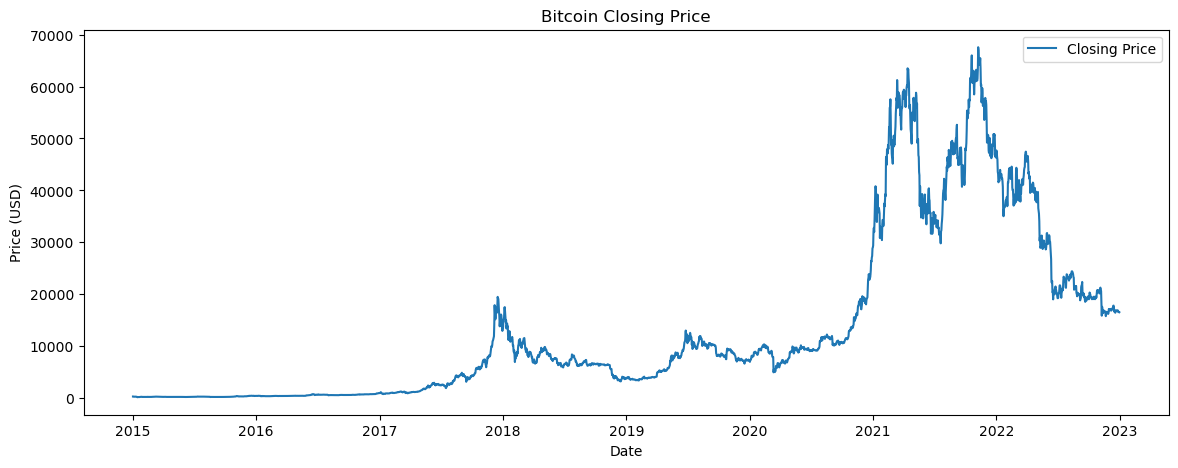

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load the data
df = yf.download('BTC-USD', start='2015-01-01', end='2023-01-01')
df = df[['Close']]

# Plot the closing price
plt.figure(figsize=(14, 5))
plt.plot(df['Close'], label='Closing Price')
plt.title('Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [3]:
# Prepare the data for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create a function to prepare the data with given time steps
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Set the time step
time_step = 60

# Split the data into training and testing sets
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [4]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)


C:\Users\rbavi\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 61s 24ms/step - loss: 0.0030
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - loss: 6.6385e-04
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - loss: 4.3364e-04
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 58s 25ms/step - loss: 4.2191e-04
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 67s 29ms/step - loss: 3.5826e-04
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 62s 27ms/step - loss: 2.0582e-04
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - loss: 2.9526e-04
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - loss: 2.0498e-04
Epoch 9/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - loss: 2.1807e-04
Epoch 10/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - loss: 2.2595e-04


In [5]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform the predictions back to the original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Transform the actual values back to the original scale
y_train_actual = scaler.inverse_transform([y_train]).reshape(-1, 1)
y_test_actual = scaler.inverse_transform([y_test]).reshape(-1, 1)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train RMSE: 711.7773642093921
Test RMSE: 1664.4012969067621


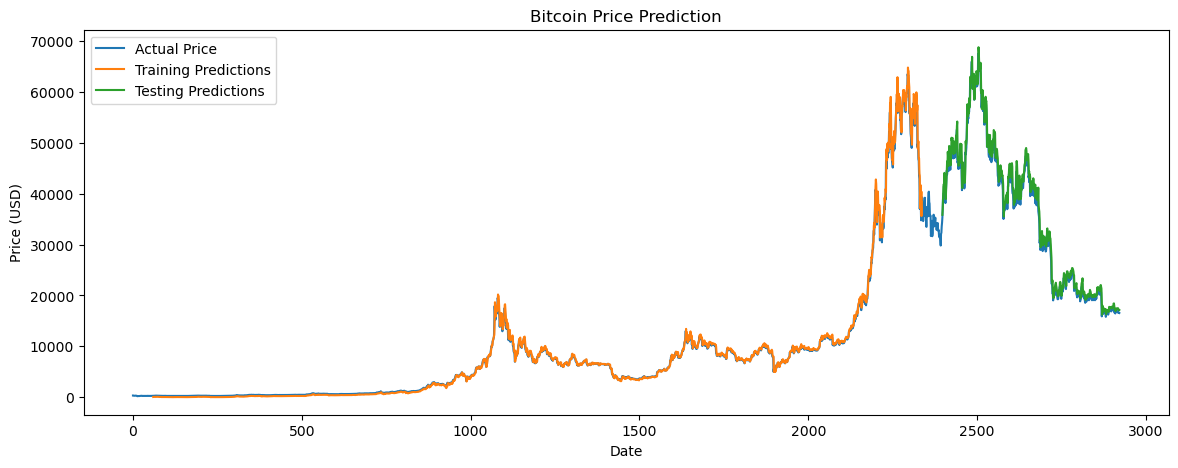

In [6]:
# Plot the results
train_data_len = len(train_data)
test_data_len = len(test_data)

# Shift the training predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:time_step + len(train_predict), :] = train_predict

# Shift the testing predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[time_step + train_data_len:time_step + train_data_len + len(test_predict), :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Price')
plt.plot(train_predict_plot, label='Training Predictions')
plt.plot(test_predict_plot, label='Testing Predictions')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [7]:
# Evaluate the model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R-squared (R2): {r2}')

print("Train Data Evaluation:")
evaluate_model(y_train_actual, train_predict)

print("\nTest Data Evaluation:")
evaluate_model(y_test_actual, test_predict)


Train Data Evaluation:
Mean Squared Error (MSE): 506627.01620086964
Root Mean Squared Error (RMSE): 711.7773642093921
Mean Absolute Error (MAE): 363.6780703777237
R-squared (R2): 0.9963406347431925

Test Data Evaluation:
Mean Squared Error (MSE): 2770231.6771449116
Root Mean Squared Error (RMSE): 1664.4012969067621
Mean Absolute Error (MAE): 1291.8610770089285
R-squared (R2): 0.9863191961378219
